In [1]:
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from d2l import torch as d2l
import random
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# Загрузка из MNIST
class FashionMNIST(d2l.DataModule): #@save
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([
            transforms.Resize(resize),
            transforms.ToTensor() ])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True
        )
        
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True
        )

In [3]:
data = FashionMNIST(resize=(32, 32))
print(f'num of train img: {len(data.train)}, num of val img: {len(data.val)}')

num of train img: 60000, num of val img: 10000


In [4]:
# Данные представляются в виде тензоров (c, h, w), where c is channel of color
data.train[0][0].shape

torch.Size([1, 32, 32])

In [5]:
@d2l.add_to_class(FashionMNIST) #@save
def text_labels(self, indices):
    labels =  ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(idx)] for idx in indices]

In [6]:
data.text_labels([1, 2])

['trouser', 'pullover']

In [7]:
@d2l.add_to_class(FashionMNIST) #@save
def get_dataloader(self, train=True):
    data = self.train if train else self.val
    return DataLoader(data, batch_size=self.batch_size, shuffle=train, num_workers=0)


In [8]:
X, y = next(iter(data.get_dataloader(train=True)))
X.shape, y.shape, y.dtype

(torch.Size([64, 1, 32, 32]), torch.Size([64]), torch.int64)

In [9]:
tic = time.time()
for X, y in data.get_dataloader():
    continue
f"{time.time()-tic} sec"

'10.248000621795654 sec'

In [10]:
def show_images(imgs, num_rows, num_cols, title=None, scale=1.5): #@save
    raise NotImplementedError


In [11]:
@d2l.add_to_class(FashionMNIST) #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)


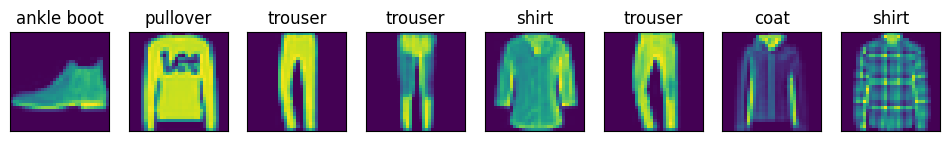

In [12]:
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

In [13]:
def text_labels(indices):
    labels =  ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(idx)] for idx in indices]

In [14]:
# Модель классификатора
class Classifier(d2l.Module): #@save
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
        

In [15]:
@d2l.add_to_class(d2l.Module) #@save
def configure_optimizer(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)


In [16]:
@d2l.add_to_class(Classifier) #@save
def accuracy(self, Y_hat, Y, average=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if average else compare

In [17]:
def softmax(X):
    norm = torch.exp(X).sum(dim=1, keepdim=True)
    result = X.exp() / norm
    return result


In [18]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs), requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)
    def parameters(self):
        return [self.W, self.b]

In [19]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

In [20]:
y = torch.tensor([0, 1])
y_hat = torch.tensor([[1, 0, 0], [0, 0.2, 0.999]])
answer = y_hat[[0, 1], y]
print(answer)

tensor([1.0000, 0.2000])


In [21]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

In [22]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

In [23]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=28*28, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [43]:
X, y = next(iter(d2l.FashionMNIST().get_dataloader(train=False)))
preds = model(X).argmax(dim=1)
    

In [52]:
print(f"Batch size of inputs is : {X.shape[0]}")
print(f"Number of correct classifications: {len(y[y==preds])}")
print(f"Number of incorrect classifications: {len(y[y!=preds])}")

Batch size of inputs is : 64
Number of correct classifications: 54
Number of incorrect classifications: 10


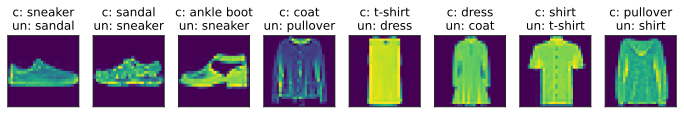

In [61]:
# Let's output some incorrectly recognized images
wrong = y != preds
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = ['c: '+a+'\n'+'un: '+b for a, b in zip(text_labels(y), text_labels(preds))]
data.visualize([X, y], labels=labels)